In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import re

from imblearn.over_sampling import SMOTE
from lazypredict.Supervised import LazyClassifier
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_embeddings = pd.read_excel('/Users/axhermosillo/Desktop/Tec/8vo Semestre/Bloque Integrador/CV_Classifier/CVClassifier/output.xlsx', sheet_name='Embeddings')
df_cvs = pd.read_excel('/Users/axhermosillo/Desktop/Tec/8vo Semestre/Bloque Integrador/CV_Classifier/CVClassifier/output.xlsx', sheet_name='CVs')

In [3]:
def convert_embedding(embedding_str):
    embedding_str = embedding_str.strip('[]')
    if embedding_str[0] == ' ':
        embedding_str = embedding_str[1:]
    embedding_list = re.split(r'\s+', embedding_str)
    embedding_array = np.array([float(x) for x in embedding_list if x], dtype=float)
    return embedding_array

def convert_for_training(df, df_norm, num_clusters):
    """
    Extract the features and generate a matrix with CVs as the rows and frequency of clusters as the columns.
    """
    keys = df['index'].unique()
    X = {k: np.zeros(num_clusters+1) for k in keys}
    
    for _, row in df.iterrows():
        X[row['index']][row['cluster']] += 1
    
    for key, value in X.items():
        X[key][ :-1] = X[key][ :-1] / df_norm.iloc[key] if df_norm.iloc[key] != 0 else X[key][ :-1]
        X[key][-1] = df_norm.iloc[key] / 100
    
    df_result = pd.DataFrame(X)

    return df_result.T

def extract_features(df, index_column, sentence_column):
    """
    Extract features that are easy to obtain from the df
    """
    # Combine all sentences from each record into a single document
    df['combined_sentences'] = df.groupby(index_column)[sentence_column].transform(lambda x: " ".join(x))

    # Remove duplicates to get a single document per record
    unique_df = df.drop_duplicates(subset=[index_column, 'combined_sentences'])

    # Get the TF-IDF
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(unique_df['combined_sentences']).toarray()
    tfidf_df = pd.DataFrame(tfidf, index=unique_df[index_column])
    print("TF-IDF Shape:", tfidf_df.shape)

    # Get the word frequency
    vectorizer = CountVectorizer()
    wf = vectorizer.fit_transform(unique_df['combined_sentences']).toarray()
    wf_df = pd.DataFrame(wf, index=unique_df[index_column])
    print("Word Frequency Shape:", wf_df.shape)

    return tfidf_df, wf_df, vectorizer
    

def find_missing_values(nums, n):
    full_set = set(range(n + 1))    
    nums_set = set(nums)
    
    missing_values = full_set - nums_set
    
    return sorted(list(missing_values))

def get_top_k_cluster_frequencies(df, groupby, cluster_column, k=5):
    """
    Returns the frequency of clusters grouped by groupby
    """
    batches = []
    df_group = df.groupby(groupby)
    df_group.apply(lambda x: batches.append(x[cluster_column].value_counts().head(k)))  #include_groups=False
    return batches


def get_appereances(freq_list):
    """
    Get the number of appereances of each cluster in all the lists
    """
    appereances = {}
    for batch in freq_list:
        for number in batch.index.values:
            if number in appereances.keys():
                appereances[number] += 1
            else:
                appereances[number] = 1
        # [appereances[number] += 1 for number in batch.index.values]
        # print(batch.index.values)
    return pd.Series(appereances)


def get_sentences_in_cluster(df, sentence_column, cluster_column, cluster):
    """
    Returns the tokens that are related to one cluster
    """
    return df[df[cluster_column] == cluster][sentence_column]

In [4]:
print('Embeddings:')
display(df_embeddings.head())
print(df_embeddings.shape)
print(df_embeddings.dtypes)

print('CVs:')
display(df_cvs.head())
print(df_cvs.shape)
print(df_cvs.dtypes)


Embeddings:


,label,index,sentence,embedding,len
0,Gerente,0,leader experience supply chain quality leaders...,[-4.47424054e-02 2.24276166e-02 5.02501056e-...,57
1,Gerente,0,o id na project implementation emphasis manage...,[-2.00967677e-02 5.39981909e-02 -2.66174022e-...,57
2,Gerente,0,economic human lean pharmaceutical chemist neg...,[-3.60780656e-02 -1.95347006e-03 -3.81188877e-...,57
3,Gerente,0,address diagonal house mail hot mail understan...,[-7.89540994e-04 1.34884324e-02 5.60681103e-...,57
4,Gerente,0,customer need decision making conflict resolut...,[-3.67572196e-02 1.91883203e-02 1.27373321e-...,57


(80167, 5)
label        object
index         int64
sentence     object
embedding    object
len           int64
dtype: object
CVs:


,label,index,text
0,Gerente,0,leader experience supply chain quality leaders...
1,Gerente,1,profile chemical engineer experience project m...
2,Gerente,2,yahoo cell graduate public accounting speciali...
3,Gerente,3,mechanical electrical engineer contact rel coa...
4,Gerente,4,environmental health safety manager risk manag...


(2065, 3)
label    object
index     int64
text     object
dtype: object


In [5]:
nums = df_cvs['index']
n = 2079
missing_values = find_missing_values(nums, n)
print('Índices de currículums faltantes:')
print(missing_values)
print(f'{100 - len(missing_values)/2079*100:.2f} %')

Índices de currículums faltantes:
[1407, 1411, 1413, 1414, 1416, 1417, 1420, 1421, 1422, 1425, 1430, 1431, 1435, 1436, 1437]
99.28 %


In [6]:
df = df_embeddings.copy()
df['embedding'] =df['embedding'].apply(convert_embedding)
display(df.head())
print(df.dtypes)

,label,index,sentence,embedding,len
0,Gerente,0,leader experience supply chain quality leaders...,"[-0.0447424054, 0.0224276166, 0.0502501056, 0....",57
1,Gerente,0,o id na project implementation emphasis manage...,"[-0.0200967677, 0.0539981909, -0.0266174022, -...",57
2,Gerente,0,economic human lean pharmaceutical chemist neg...,"[-0.0360780656, -0.00195347006, -0.0381188877,...",57
3,Gerente,0,address diagonal house mail hot mail understan...,"[-0.000789540994, 0.0134884324, 0.00560681103,...",57
4,Gerente,0,customer need decision making conflict resolut...,"[-0.0367572196, 0.0191883203, 0.00127373321, -...",57


label        object
index         int64
sentence     object
embedding    object
len           int64
dtype: object


In [7]:
tfidf, wf, vectorizer = extract_features(df, 'index', 'sentence')
display(tfidf.head())

TF-IDF Shape: (2065, 9651)
Word Frequency Shape: (2065, 9651)


,0,1,2,3,4,5,6,7,8,9,...,9641,9642,9643,9644,9645,9646,9647,9648,9649,9650
index,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
kmeans = KMeans(n_clusters=42, random_state=0, n_init="auto").fit(df['embedding'].to_list())
df['cluster'] = kmeans.labels_
df.head()

,label,index,sentence,embedding,len,combined_sentences,cluster
0,Gerente,0,leader experience supply chain quality leaders...,"[-0.0447424054, 0.0224276166, 0.0502501056, 0....",57,leader experience supply chain quality leaders...,31
1,Gerente,0,o id na project implementation emphasis manage...,"[-0.0200967677, 0.0539981909, -0.0266174022, -...",57,leader experience supply chain quality leaders...,13
2,Gerente,0,economic human lean pharmaceutical chemist neg...,"[-0.0360780656, -0.00195347006, -0.0381188877,...",57,leader experience supply chain quality leaders...,3
3,Gerente,0,address diagonal house mail hot mail understan...,"[-0.000789540994, 0.0134884324, 0.00560681103,...",57,leader experience supply chain quality leaders...,37
4,Gerente,0,customer need decision making conflict resolut...,"[-0.0367572196, 0.0191883203, 0.00127373321, -...",57,leader experience supply chain quality leaders...,1


In [9]:
cluster_freq = get_top_k_cluster_frequencies(df[df['label'] == 'Director'], groupby='index', cluster_column='cluster')
director_appereances = get_appereances(cluster_freq)
director_appereances = director_appereances.sort_values(ascending=False).head(5)

cluster_freq = get_top_k_cluster_frequencies(df[df['label'] == 'Gerente'], groupby='index', cluster_column='cluster')
gerente_appereances = get_appereances(cluster_freq)
gerente_appereances = gerente_appereances.sort_values(ascending=False).head(5)

cluster_freq = get_top_k_cluster_frequencies(df[df['label'] == 'Especialista'], groupby='index', cluster_column='cluster')
especialista_appereances = get_appereances(cluster_freq)
especialista_appereances = especialista_appereances.sort_values(ascending=False).head(5)

print('Director:')
print(director_appereances)

print('Gerente:')
print(gerente_appereances)

print('Especialista:')
print(especialista_appereances)

Director:
10    20
37    15
39    12
31    11
20    11
dtype: int64
Gerente:
10    361
39    343
18    336
14    326
31    306
dtype: int64
Especialista:
30    148
25    141
16    133
38    120
37    101
dtype: int64


In [10]:
X = convert_for_training(df, df['len'], num_clusters=42)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.02,0.04,0.00,0.14,0.00,0.02,0.02,0.05,0.12,0.00,...,0.05,0.02,0.02,0.02,0.02,0.00,0.02,0.02,0.00,0.57
1,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.04,0.05,...,0.05,0.00,0.00,0.00,0.00,0.02,0.04,0.00,0.02,0.57
2,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.04,0.23,...,0.00,0.02,0.00,0.07,0.00,0.00,0.04,0.00,0.04,0.57
3,0.00,0.00,0.00,0.02,0.02,0.00,0.00,0.04,0.09,0.02,...,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.00,0.04,0.57
4,0.02,0.00,0.04,0.02,0.02,0.00,0.00,0.02,0.02,0.00,...,0.00,0.00,0.28,0.02,0.00,0.00,0.02,0.02,0.04,0.57


In [11]:
X.shape

(2065, 43)

In [12]:
label_encoder = preprocessing.LabelEncoder()

y = label_encoder.fit_transform(df_cvs['label'])
print(y.shape)
y

(2065,)


array([2, 2, 2, ..., 1, 1, 1])

In [35]:
X_ld = np.array(X)
clf = LDA()
model = clf.fit(X_ld, y).transform(X_ld)
clf.score(X_ld, y)

0.8

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_ld, y, test_size=.14,random_state =123, stratify=y)

smote = SMOTE(random_state=123)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train_res, X_test, y_train_res, y_test)

print(models)

 97%|█████████▋| 28/29 [00:08<00:00,  3.22it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10964
[LightGBM] [Info] Number of data points in the train set: 4182, number of used features: 43
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


100%|██████████| 29/29 [00:09<00:00,  3.11it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
LGBMClassifier                     0.96               0.94    None      0.96   
XGBClassifier                      0.95               0.90    None      0.95   
BaggingClassifier                  0.89               0.86    None      0.89   
DecisionTreeClassifier             0.80               0.79    None      0.82   
CalibratedClassifierCV             0.72               0.78    None      0.76   
AdaBoostClassifier                 0.64               0.76    None      0.68   
KNeighborsClassifier               0.66               0.74    None      0.70   
LogisticRegression                 0.72               0.74    None      0.76   
RidgeClassifierCV                  0.60               0.74    None      0.65   
RidgeClassifier                    0.60               0.74    None      0.65   
LinearSVC                          0.70 

In [13]:
A = X.copy()
B = tfidf.copy()

A =  A.rename(columns=lambda x: f'X_{x}')
B =  B.rename(columns=lambda x: f'tfidf_{x}')

C = pd.concat([A, B], axis=1)

In [28]:
C.shape

(2065, 9694)

In [14]:
C_ld = np.array(C)
clf = LDA()
model = clf.fit(C_ld, y).transform(C_ld)
clf.score(C_ld, y)

0.9946731234866828

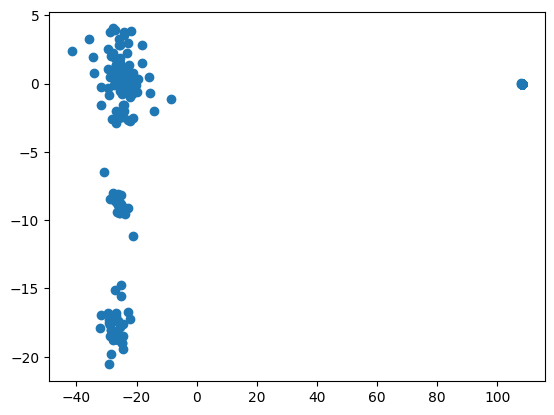

In [15]:
x_lda = (model[:, 0])
y_lda = (model[:, 1])

plt.scatter(x_lda, y_lda)

Text(0.5, 1.0, 'LDA')

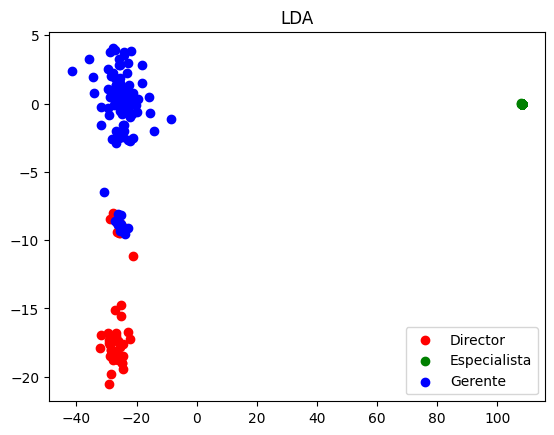

In [16]:
target_names = ['Director', 'Especialista', 'Gerente']
target_names = np.array(target_names)

for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(model[y == i, 0], model[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA')

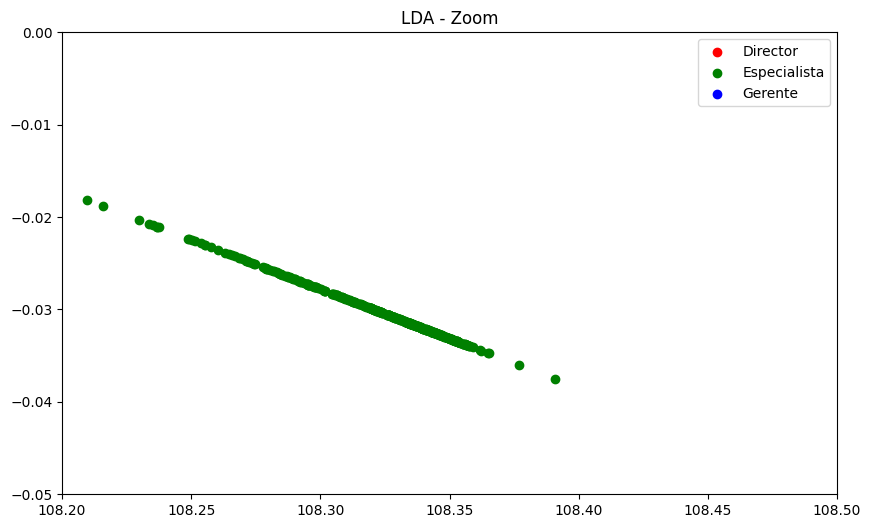

In [27]:
plt.figure(figsize=(10, 6))

for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(model[y == i, 0], model[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA - Zoom')

plt.xlim(108.2, 108.5)  
plt.ylim(-0.05, 0)    

plt.show()